# Overview

## Aim
To interpret the celloracle simulation results, it is essential to compare the direction of the perturbation effect with natural differentiation. By comparing them, you can intuitively understand how TF is involved in cell fate determination during development. This perspective is also needed when estimating experimental perturbation results using celloracle simulations.

## Method summary
For that purpose, we will introduce how to calculate the direction of differentiation using "pseudotime estimation" and "gradient calculation". Here's an overview of how to do this:

1. Calculate the pseudotime using the diffusion pseudotime method (dpt).
2. Transfer pseudotime data to grid points
3. Calculate the 2D gradient vector field using the pseudotime on the grid points
4. Compute the inner product value between the 2D gradient vector and the celloracle simulation vector to compare the simulated cell identity shift direction with the development direction.


**In this notebook, we will do step1: pseudotime calculation.**
The pseudotime calculation part consists of these steps below.
1. Set lineage information and split the cells into several lineage brahches
2. Set root cells manually
3. Calculate pseudotime with dpt algorithm.
4. Re-aggregate scRNA-seq data into one data

## Custom class / object

`Pseudotime_calculator`: This is a celloracle class for the pseudotime calculation. This class help us calculate pseudotime from scRNA-seq data. We need to specify root cell. Also, scRNA-seq need to have a diffusion map
>Under the hood, Pseudotime_calculator uses "dpt" function.
For more information of dpt function, please look at the scanpy web documentation.
https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt

## Data

Pseudo-time calculation requires preprocessed scRNA-seq data in anndata format.
You need to do the following calculations in advance. If you have processed the scRNA-seq data according to our tutorial (link), these calculations should have already been performed.
- Neighbor calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.neighbors.html#scanpy.pp.neighbors
- Diffusion map calculation: https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.diffmap.html#scanpy.tl.diffmap


## Install additional python package

This notebook we recommend using another python package, `plotly`. 

Please install `plotly` in advance. 

`pip install plotly`

> Plotly is a toolkit for interactive visualization.
We recommend using plotly to pick up root cells in this notebook.
For more information, please look at plotly web site. https://plotly.com



## Caution
Here, we will introduce an example of a pseudotime calculation method using the diffusion pseudotime method.
This is NOT celloracle analysis itself.
If you want to use another different algorithm for the pseudotime calculation, you can use anything.



# 0. Import libraries
## 0.1. Import public libraries

In [3]:
import copy
import glob
import importlib
import time
import os
import shutil
import sys
from importlib import reload

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from tqdm.notebook import tqdm

#import time

## 0.2. Import our library

In [2]:
import celloracle as co
from celloracle.applications import Pseudotime_calculator
co.__version__

'0.7.0'

## 0.3. Plotting parameter setting

In [20]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [5,5]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 300

%matplotlib inline

# 1. Load data

We can add pseudotime calculation to an oracle object or to anndata.

- If you have oracle object, please run **1.1.[Option1] Load oracle data.**

- If you have not made oracle object yet and want to calculate pseudotime using anndata, please run **1.2.[Option2] Load anndata.** 

In this notebook, we load demo oracle object to add pseudotime.

## 1.1. [Option1] Load oracle data

In [13]:
# Load demo scRNA-seq data.
oracle = co.data.load_tutorial_oracle_object()

# Instantiate pseudotime object using oracle object.
pt = Pseudotime_calculator(oracle_object=oracle)

In [14]:
pt = Pseudotime_calculator??

In [ ]:
pt = Pseudotime_calculator

In [15]:
adata

Oracle object

Meta data
    celloracle version used for instantiation: 0.6.11
    n_cells: 2671
    n_genes: 1999
    cluster_name: louvain_annot
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 21259 genes
    n_regulatory_in_TFdict: 1093 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 90 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1850 genes
    k_for_knn_imputation: 66
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

In [16]:
# Load demo scRNA-seq data.
adata = co.data.load_Paul2015_data()
pt = Pseudotime_calculator(adata=adata,
                           obsm_key="X_draw_graph_fa", # Dimensional reduction data name
                           cluster_column_name="louvain_annot" # Clustering data name
                           )


# 2. Pseudotime calculation

## 2.1. Add lineage information

We will calculate pseudotime for each lineage. We need to set lineage information first.

### 2.1.1 Check clustering unit

In [17]:
print("Clustering name: ", pt.cluster_column_name)
print("Cluster list", pt.cluster_list)

Clustering name:  louvain_annot
Cluster list ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'MEP_0', 'Mk_0', 'Mo_0', 'Mo_1', 'Mo_2']


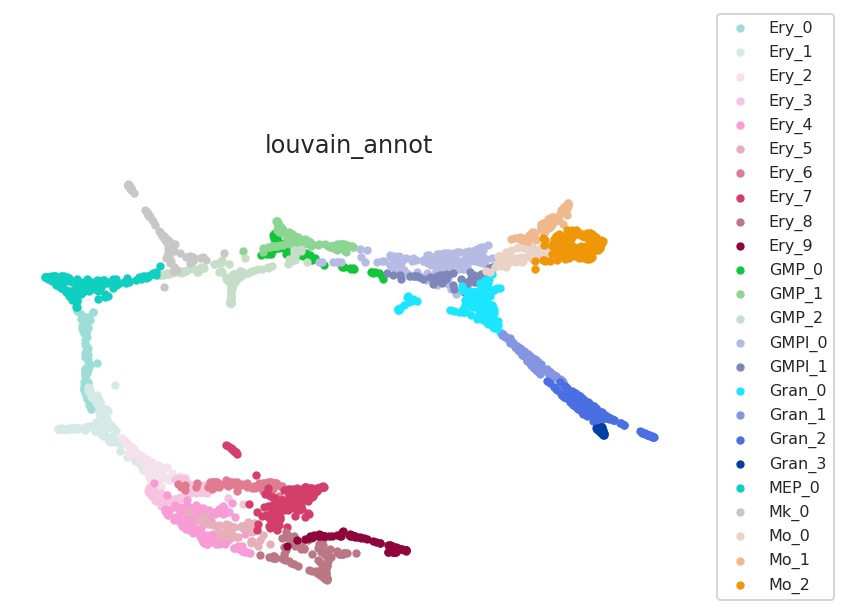

In [23]:
# Check data
pt.plot_cluster(fontsize=8)

### 2.1.2. Define llineage

The scRNA-seq data will be annotated with lineage information.
For example, this scRNA-seq data include roughly two lineages: MEP and GMP lineage.
To get better pseudotime information, we will calculate pseudotime for each lineage separatedly. 
And then, pseudotime information for each lineage will be merged to one.

Please set lineage information as follows. Of course, the details of lineage information such as the structure an the number of lineages can vary depending on your data.

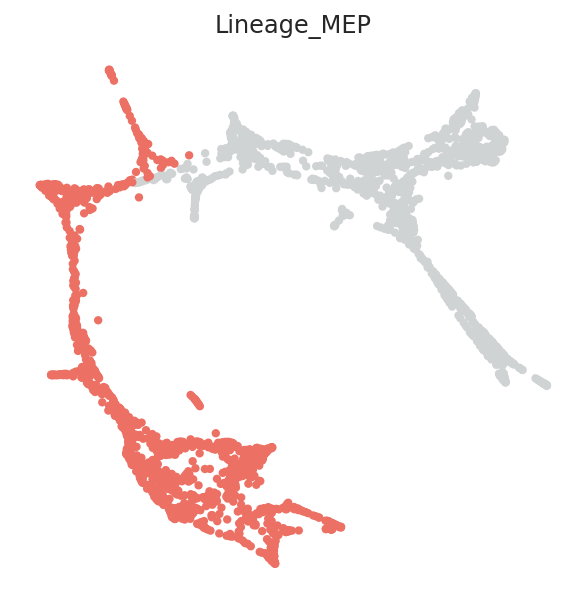

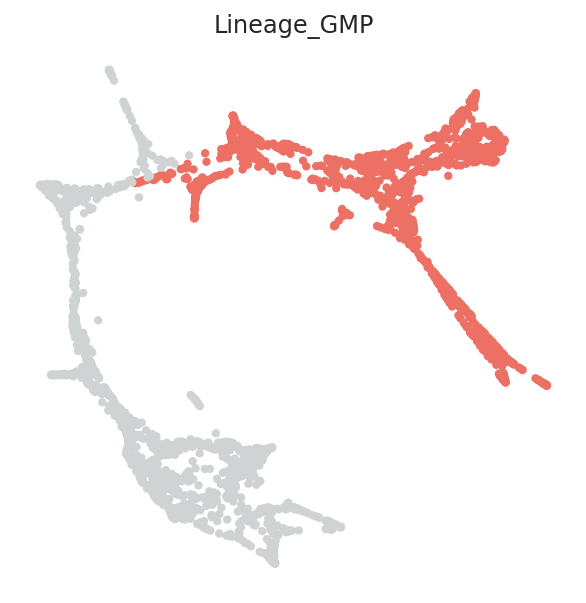

In [8]:
# These cluster can be classified into either MEP lineage or GMP lineage

clusters_in_MEP_lineage = ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9', 'MEP_0', 'Mk_0']
clusters_in_GMP_lineage = ['GMP_0', 'GMP_1', 'GMP_2', 'GMPl_0', 'GMPl_1', 'Gran_0', 'Gran_1', 'Gran_2', 'Gran_3', 'Mo_0', 'Mo_1', 'Mo_2']

# Make dictionary
lineage_dictionary = {"Lineage_MEP": clusters_in_MEP_lineage,
           "Lineage_GMP": clusters_in_GMP_lineage}

# Inpur lineage information into pseudotime object
pt.set_lineage(lineage_dictionary=lineage_dictionary)

# Visualize lineage information
pt.plot_lineages()

# 2.2. Add root cell information

The pseudotime calculation with dpt requires to input root cell.
We will manyally estimate root cell for each lineage.

Please read documentation (https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt) to find detailed information about dpt algorithm and root cells

### 2.2.1. (optional) Interactive visualization of cell name 

This notebook we recommend using another python package, `plotly`. 

Please install `plotly` in advance. 

`pip install plotly`

> Plotly is a toolkit for interactive visualization.
We recommend using plotly to pick up root cells in this notebook.
For more information, please look at plotly web site. https://plotly.com




**Using plotly, we can visualize cell name interactively. It helps us pick up a root cell.**
<img src="./screenshot_01.png">

In [31]:

try:
    import plotly.express as px
    def plot(adata, embedding_key, cluster_column_name):
        embedding = adata.obsm[embedding_key]
        df = pd.DataFrame(embedding, columns=["x", "y"])
        df["cluster"] = adata.obs[cluster_column_name].values
        df["label"] = adata.obs.index.values
        fig = px.scatter(df, x="x", y="y", hover_name=df["label"], color="cluster")
        fig.show()
        
    plot(adata=pt.adata,
         embedding_key=pt.obsm_key,
         cluster_column_name=pt.cluster_column_name)
except:
    print("Found error. Did you install plotly? Please read the instruction above.")


In [ ]:
plot(adata)

<img src="./screenshot_01.png">

### 2.2.2. Select root cell for each lineage

In [10]:
#  Estimated root cell name for each lineage
root_cells = {"Lineage_MEP": "1539", "Lineage_GMP": "2244"}
pt.set_root_cells(root_cells=root_cells)

### 2.2.3. Visualize root cells 

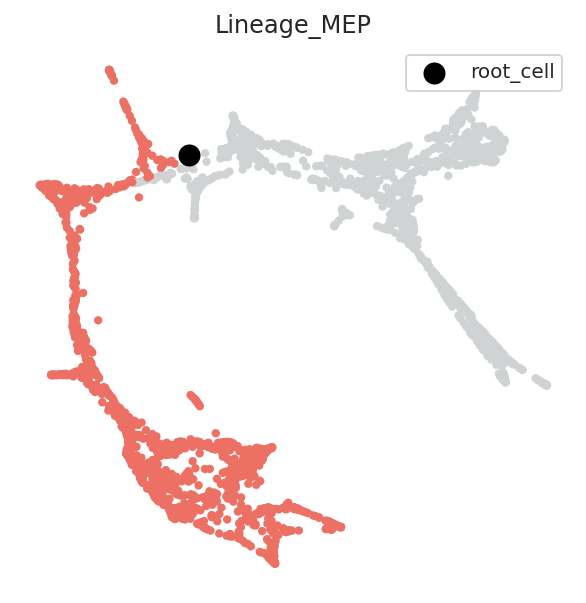

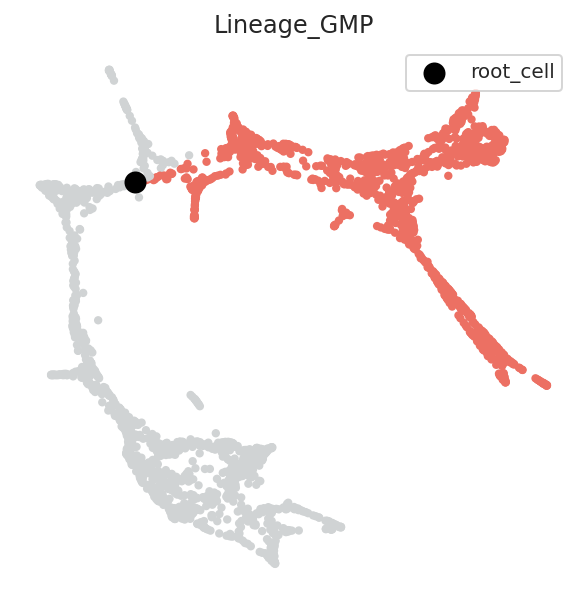

In [11]:
# Check root cell and lineage
pt.plot_root_cells()


## 2.3. Pseudotime calculation

### 2.3.1. Diffusion map data

dpt function in scanpy will be used for the psudotime calculation.
The function use diffusion map data. 
Please calculate diffusionmap if your data does not have one.

Even if your data already have diffusion map data, you can calculate diffusion map again.
Some hyper prarameters can be adjustable. Please come back here to try another hyper prarameters for diffusion map if you get a bad pseudotime result in the later process.

For more information of dpt and diffusion map, pleas go https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.diffmap.html#scanpy.tl.diffmap


In [12]:
# Check diffusion map data.
"X_diffmap" in pt.adata.obsm


True

Calculate diffusion map if your adata does not have diffusion map data



In [13]:
# sc.pp.neighbors(pt.adata, n_neighbors=30)
# sc.tl.diffmap(pt.adata)

Diffusion maps can be calculated in the anther dimensionality reduction space.
Please adjust this parameter "use_rep" to get another better results if you have a issue in the following calculation.

In [14]:
# sc.pp.neighbors(pt.adata, n_neighbors=30, use_rep=)
# sc.tl.diffmap(pt.adata)

### 2.3.2. Calculate pseudotime

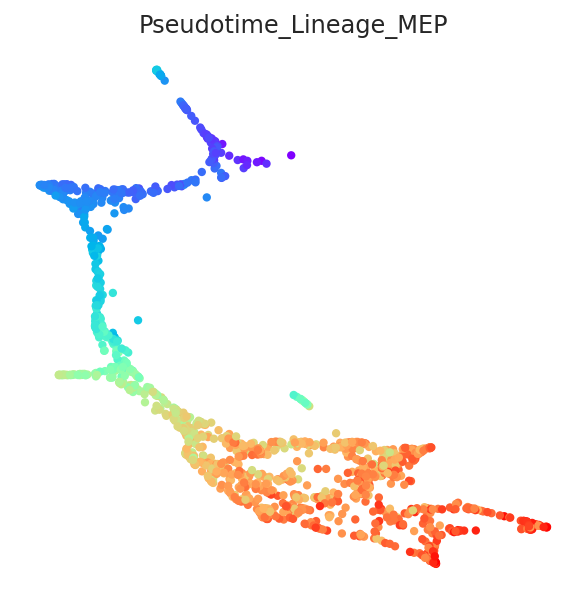

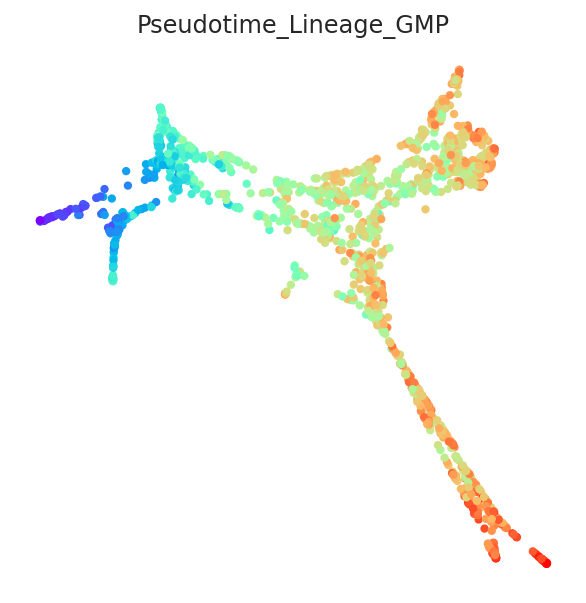

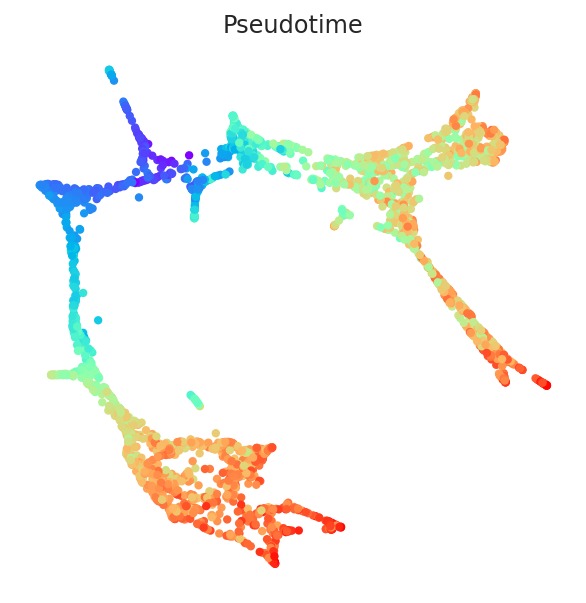

In [15]:
# Calculate pseudotime
pt.get_pseudotime_per_each_lineage()

# Check results
pt.plot_pseudotime(cmap="rainbow")

In [16]:
# Check result 
pt.adata.obs.head()

,paul15_clusters,n_counts_all,n_counts,louvain,cell_type,louvain_annot,Lineage_MEP,Lineage_GMP,Pseudotime_Lineage_MEP,Pseudotime_Lineage_GMP,Pseudotime
index,,,,,,,,,,,
0,7MEP,353.0,1159.903931,3,MEP,MEP_0,True,False,0.175565,NaN,0.175565
1,15Mo,2556.0,1257.984985,0,Monocytes,Mo_2,False,True,NaN,0.712654,0.712654
2,3Ery,4649.0,1120.304810,11,Erythroids,Ery_8,True,False,0.953920,NaN,0.953920
3,15Mo,4486.0,1209.461060,12,Granulocytes,Gran_1,False,True,NaN,0.642302,0.642302
4,3Ery,5205.0,1155.348145,11,Erythroids,Ery_8,True,False,0.951093,NaN,0.951093


# 3. Save data

In [17]:
# Update oracle object
oracle.adata.obs = pt.adata.obs

# Save updated oracle object
oracle.to_hdf5("../data/Paul_etal_with_pseudotime_v201212.celloracle.oracle")